In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, sampler, random_split, ConcatDataset
from torchvision.datasets import ImageFolder
import random
from PIL import Image
import matplotlib.pyplot as plt

DATASET_PATH = "./Dataset/"
device = torch.device('cuda:0' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))
device

device(type='cuda', index=0)

Primero veremos la distribucion de los datos.

In [ ]:
classes = os.listdir(DATASET_PATH)
VALUES = 0
for c in classes:
    size = len(os.listdir(DATASET_PATH + c))
    VALUES += size
    print(f"{c}: {size} images")
print("Total values:", VALUES)


Moderate_Demented: 64 images
Mild_Demented: 896 images
Non_Demented: 3200 images
Very_Mild_Demented: 2240 images
Total values: 6400


Ahora los cargaremos.

In [ ]:
# Definir transformaciones para preprocesamiento de las imágenes en blanco y negro
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalizar los valores de píxeles para una sola dimensión
])

dataset = ImageFolder(root=DATASET_PATH, transform=transform)

# Definir la proporción de división para entrenamiento, validación y testing
train_size = int(0.7 * len(dataset))  # 70% para entrenamiento
val_size = int(0.15 * len(dataset))   # 15% para validación
test_size = len(dataset) - train_size - val_size  # Restante para testing

print(train_size, val_size, test_size)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Especificar parámetros para los DataLoaders de entrenamiento, validación y testing
batch_size = 32
shuffle_train = True
shuffle_val = False
shuffle_test = False

# Crear DataLoaders para el conjunto de entrenamiento, validación y testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle_train)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle_val)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle_test)

4480 960 960


In [ ]:
print(train_loader.dataset)

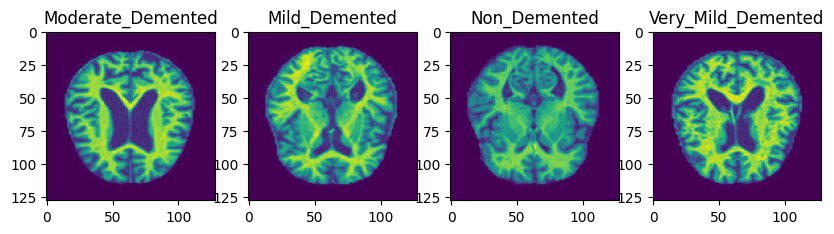

In [ ]:
subfolders = [f.path for f in os.scandir(DATASET_PATH) if f.is_dir()]
num_columns = len(subfolders)

plt.figure(figsize=(10, 10))

for i, subfolder in enumerate(subfolders):
    image_files = [f for f in os.listdir(subfolder)]

    selected_image_file = random.choice(image_files) # Seleccionar una imagen aleatoria por clase

    image = Image.open(os.path.join(subfolder, selected_image_file))

    plt.subplot(1, num_columns, i + 1)
    plt.title(subfolder[10:])
    plt.imshow(image)

plt.show()

In [ ]:
for image_batch, labels_batch in test_loader:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

torch.Size([32, 3, 128, 128])
torch.Size([32])


Definimos la funcion para hacer el entrenamiento

In [ ]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for xi, yi in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi)
            _, pred = scores.max(dim=1)
            num_correct += (pred == yi).sum()
            num_total += pred.size(0)
        return float(num_correct)/num_total

In [ ]:

def train(model, optimiser, epochs=100):
    model = model.to(device=device)
    loss = []
    acc = []
    for epoch in range(epochs):
        for i, (xi, yi) in enumerate(train_loader):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            cost = F.cross_entropy(input= scores, target=yi)
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
        loss.append(cost.item())
        a = accuracy(model, val_loader)
        acc.append(a)
        print(f'Epoch: {epoch}, cost: {cost.item()}, accuracy: {a}')
    return loss, acc


In [ ]:
def see_results(name, model, lr, epochs):
    optimiser = torch.optim.Adam(model.parameters(), lr=lr)
    loss, acc = train(model, optimiser, epochs)
    accuracys = accuracy(model, test_loader)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Model: " + name + " - Accuracy: " + str(round(accuracys*100, 2)) + " %")
    plt.plot(loss, 'blue', label="Loss")
    plt.plot(acc, 'orange', label="Accuracy")
    plt.legend(loc='best', facecolor='w', fontsize=16)
    plt.show()

# Modelos

1. Sequential Linear

In [ ]:
class SequentialLinear(torch.nn.Module):
    def __init__(self):
        super().__init__()
        layers = [nn.Flatten(),
                       nn.Linear(in_features=128*128*3, out_features=128), nn.ReLU(),
                       nn.Linear(in_features=128, out_features=128), nn.ReLU(),
                       nn.Linear(in_features=128, out_features=4)]

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

Epoch: 0, cost: 0.7853373289108276, accuracy: 0.5791666666666667
Epoch: 1, cost: 0.5382677316665649, accuracy: 0.6333333333333333
Epoch: 2, cost: 0.6499029397964478, accuracy: 0.61875
Epoch: 3, cost: 0.5498102307319641, accuracy: 0.7135416666666666
Epoch: 4, cost: 0.4899570345878601, accuracy: 0.771875
Epoch: 5, cost: 0.3068849742412567, accuracy: 0.7989583333333333
Epoch: 6, cost: 0.24524565041065216, accuracy: 0.84375
Epoch: 7, cost: 0.23081225156784058, accuracy: 0.8458333333333333
Epoch: 8, cost: 0.17513532936573029, accuracy: 0.8135416666666667
Epoch: 9, cost: 0.2274424284696579, accuracy: 0.8229166666666666
Epoch: 10, cost: 0.4153422713279724, accuracy: 0.8427083333333333
Epoch: 11, cost: 0.1475013792514801, accuracy: 0.8822916666666667
Epoch: 12, cost: 0.39040103554725647, accuracy: 0.8833333333333333
Epoch: 13, cost: 0.4272008538246155, accuracy: 0.8510416666666667
Epoch: 14, cost: 0.3250778615474701, accuracy: 0.8864583333333333
Epoch: 15, cost: 0.1748068779706955, accuracy: 0

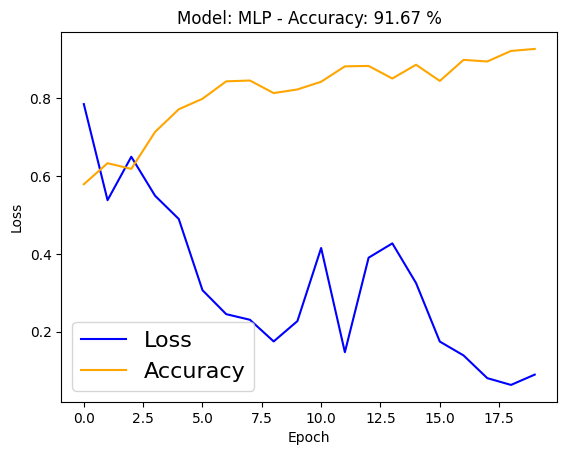

In [ ]:
model0 = SequentialLinear()
see_results("MLP", model0, lr=0.001, epochs=20)

2. Convolutional Neural Network - Version 1

In [ ]:
class CNN_1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        layers = [
            nn.Conv2d(in_channels=3, out_channels= 16, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=16, out_channels= 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(in_features=32*32*32, out_features=128), nn.ReLU(),
            nn.Linear(in_features=128, out_features=128), nn.ReLU(),
            nn.Linear(in_features=128, out_features=128), nn.ReLU(),
            nn.Linear(in_features=128, out_features=4)
        ]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

Epoch: 0, cost: 0.9749014973640442, accuracy: 0.5791666666666667
Epoch: 1, cost: 0.47564154863357544, accuracy: 0.7583333333333333
Epoch: 2, cost: 0.3535475432872772, accuracy: 0.8989583333333333
Epoch: 3, cost: 0.04070891812443733, accuracy: 0.8666666666666667
Epoch: 4, cost: 0.04793946444988251, accuracy: 0.91875
Epoch: 5, cost: 0.0980367362499237, accuracy: 0.9666666666666667
Epoch: 6, cost: 0.03270038589835167, accuracy: 0.959375
Epoch: 7, cost: 0.00012242344382684678, accuracy: 0.9791666666666666
Epoch: 8, cost: 0.0020864049438387156, accuracy: 0.9260416666666667
Epoch: 9, cost: 0.045091476291418076, accuracy: 0.9666666666666667
Epoch: 10, cost: 0.1282564401626587, accuracy: 0.9510416666666667
Epoch: 11, cost: 0.0014348645927384496, accuracy: 0.98125
Epoch: 12, cost: 0.004703150596469641, accuracy: 0.9739583333333334
Epoch: 13, cost: 0.025719311088323593, accuracy: 0.9625
Epoch: 14, cost: 0.057268623262643814, accuracy: 0.9666666666666667
Epoch: 15, cost: 0.0046859849244356155, ac

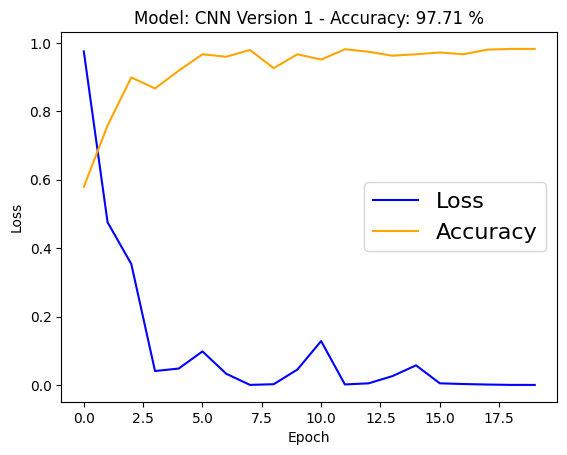

In [ ]:
model1 = CNN_1()
see_results("CNN Version 1", model1, lr=0.001, epochs=20)


In [ ]:
class CNN_2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        layers = [
            nn.Conv2d(in_channels=3, out_channels= 16, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=16, out_channels= 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=32, out_channels= 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(in_features=16*16*64, out_features=256), nn.ReLU(),
            nn.Linear(in_features=256, out_features=256), nn.ReLU(),
            nn.Linear(in_features=256, out_features=4)
        ]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

Epoch: 0, cost: 0.9963501691818237, accuracy: 0.5395833333333333
Epoch: 1, cost: 0.8549339771270752, accuracy: 0.6104166666666667
Epoch: 2, cost: 0.6712259650230408, accuracy: 0.69375
Epoch: 3, cost: 0.27909138798713684, accuracy: 0.7802083333333333
Epoch: 4, cost: 0.16837354004383087, accuracy: 0.8677083333333333
Epoch: 5, cost: 0.04818039759993553, accuracy: 0.93125
Epoch: 6, cost: 0.04447675496339798, accuracy: 0.9375
Epoch: 7, cost: 0.019198384135961533, accuracy: 0.9416666666666667
Epoch: 8, cost: 0.035986147820949554, accuracy: 0.9229166666666667
Epoch: 9, cost: 0.175208181142807, accuracy: 0.8854166666666666
Epoch: 10, cost: 0.058123935014009476, accuracy: 0.94375
Epoch: 11, cost: 0.0021892469376325607, accuracy: 0.965625
Epoch: 12, cost: 0.00020730284450110048, accuracy: 0.9697916666666667
Epoch: 13, cost: 1.6810610759421252e-05, accuracy: 0.9708333333333333
Epoch: 14, cost: 5.21156944159884e-05, accuracy: 0.96875
Epoch: 15, cost: 7.34683926566504e-05, accuracy: 0.9708333333333

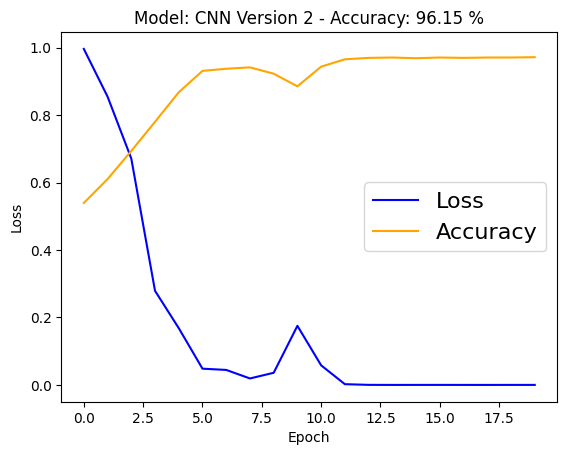

In [ ]:
model2 = CNN_2()

see_results("CNN Version 2", model2, lr=0.001, epochs=20)


In [ ]:
class CNN_3(torch.nn.Module):
    def __init__(self):
        super().__init__()
        layers = [
            nn.Conv2d(in_channels=3, out_channels= 16, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=16, out_channels= 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(in_features=32*32*32, out_features=256), nn.ReLU(),
            nn.Linear(in_features=256, out_features=256), nn.ReLU(),
            nn.Linear(in_features=256, out_features=256), nn.ReLU(),
            nn.Linear(in_features=256, out_features=256), nn.ReLU(),
            nn.Linear(in_features=256, out_features=4)
        ]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

Epoch: 0, cost: 1.0821424722671509, accuracy: 0.59375
Epoch: 1, cost: 0.9708530902862549, accuracy: 0.578125
Epoch: 2, cost: 0.15532949566841125, accuracy: 0.884375
Epoch: 3, cost: 0.1375945806503296, accuracy: 0.8822916666666667
Epoch: 4, cost: 0.04447971284389496, accuracy: 0.9385416666666667
Epoch: 5, cost: 0.04370017722249031, accuracy: 0.9604166666666667
Epoch: 6, cost: 0.0352465882897377, accuracy: 0.9020833333333333
Epoch: 7, cost: 0.0003307103179395199, accuracy: 0.965625
Epoch: 8, cost: 0.017759067937731743, accuracy: 0.9572916666666667
Epoch: 9, cost: 0.00017686582577880472, accuracy: 0.9677083333333333
Epoch: 10, cost: 0.009046544320881367, accuracy: 0.9645833333333333
Epoch: 11, cost: 0.005385404918342829, accuracy: 0.9583333333333334
Epoch: 12, cost: 0.017226139083504677, accuracy: 0.9583333333333334
Epoch: 13, cost: 0.00010915072925854474, accuracy: 0.9802083333333333
Epoch: 14, cost: 0.00010447436943650246, accuracy: 0.98125
Epoch: 15, cost: 7.958586502354592e-05, accura

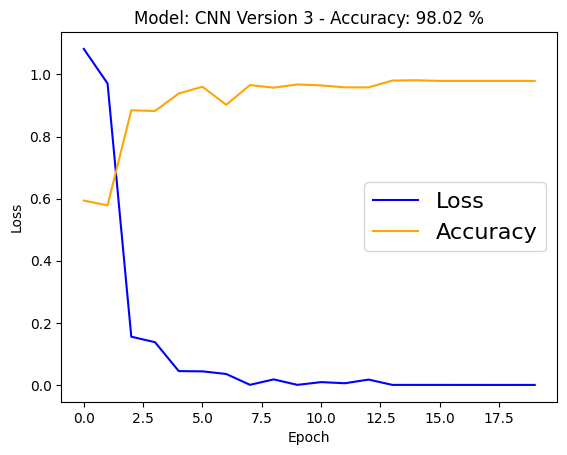

In [ ]:
model2 = CNN_3()

see_results("CNN Version 3", model2, lr=0.001, epochs=20)